In [72]:
import os
os.chdir('../..')

import numpy as np
import pandas as pd
import torch
import pickle
from tqdm import tqdm
from molexplain.utils import DATA_PATH

In [73]:
with open(os.path.join(DATA_PATH, 'caco2', 'data_caco2.pt'), 'rb') as handle:
    inchis, values = pickle.load(handle)

In [74]:
from rdkit.Chem.Crippen import MolLogP
from rdkit.Chem.rdMolDescriptors import CalcTPSA
from rdkit.Chem.Lipinski import NumHDonors
from rdkit.Chem.Descriptors import MolWt

from rdkit.Chem.inchi import MolFromInchi

mws = []
logps = []
tpsas = []
nhdonors = []

for inchi in inchis:
    mol = MolFromInchi(inchi)
    mws.append(MolWt(mol))
    logps.append(MolLogP(mol))
    tpsas.append(CalcTPSA(mol))
    nhdonors.append(NumHDonors(mol))

og_properties = pd.DataFrame({'mws': mws,
                              'logps': logps,
                              'tpsas': tpsas,
                              'nhdonors': nhdonors,
                              'values': values})

In [75]:
og_properties

,mws,logps,tpsas,nhdonors,values
0,336.432,2.36550,87.66,3,5.420216
1,151.165,1.35060,49.33,2,4.000000
2,180.159,1.31010,63.60,1,5.657577
3,285.815,-0.73070,41.49,2,3.769551
4,229.631,-1.29200,159.29,4,5.370590
...,...,...,...,...,...
271,824.972,3.51750,171.17,3,6.221849
272,778.947,4.75360,133.87,2,5.765856
273,308.333,3.60960,67.51,1,4.387504
274,267.245,0.21602,133.34,2,5.103447


In [76]:
import matplotlib.pyplot as plt
import seaborn as sns

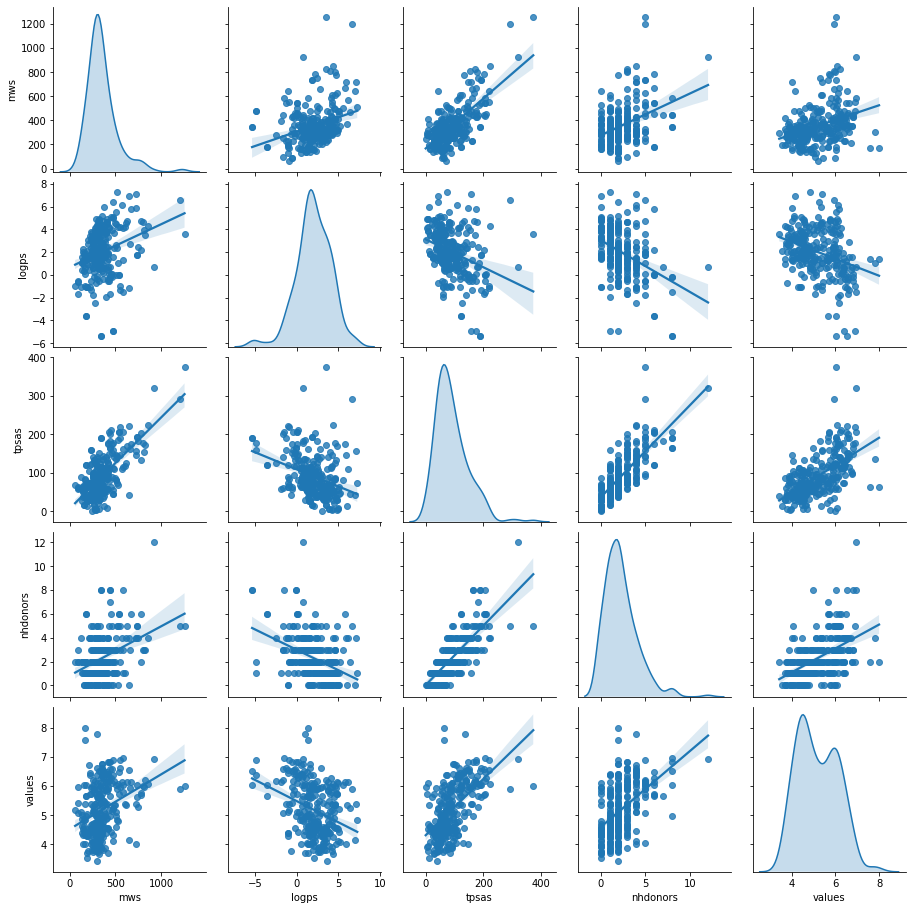

In [77]:
sns.pairplot(og_properties, diag_kind="kde", kind="reg")

In [80]:
np.corrcoef(og_properties.values.T)

array([[ 1.        ,  0.2999759 ,  0.69978552,  0.3798058 ,  0.33715376],
       [ 0.2999759 ,  1.        , -0.32902184, -0.3945924 , -0.32761234],
       [ 0.69978552, -0.32902184,  1.        ,  0.77236612,  0.58471349],
       [ 0.3798058 , -0.3945924 ,  0.77236612,  1.        ,  0.51112569],
       [ 0.33715376, -0.32761234,  0.58471349,  0.51112569,  1.        ]])

In [81]:
from molexplain.vis import molecule_importance
from molexplain.utils import MODELS_PATH
from molexplain.train import DEVICE

In [82]:
import torch
model_pt = os.path.join(MODELS_PATH, 'caco2_noHs.pt')

from molexplain.net import MPNNPredictor

model = MPNNPredictor(node_in_feats=49,
                      edge_in_feats=10,
                      global_feats=4,
                      n_tasks=1).to(DEVICE) 
model.load_state_dict(torch.load(model_pt,
                                 map_location=DEVICE))

<All keys matched successfully>

In [86]:
global_importances = []

for inchi in tqdm(inchis):
    mol = MolFromInchi(inchi)
    _, _, _, _, gi = molecule_importance(MolFromInchi(inchi),
                                         model,
                                         task=0,
                                         version=2,
                                         vis_factor=1,
                                         eps=1e-3,
                                         addHs=False)
    global_importances.append(gi)

100%|██████████| 276/276 [05:39<00:00,  1.23s/it]


In [87]:
global_importances = np.array(global_importances) * 100
global_importances = pd.DataFrame(data=global_importances, columns=['mws', 'logps', 'tpsas', 'nhdonors'])
global_importances['values'] = values

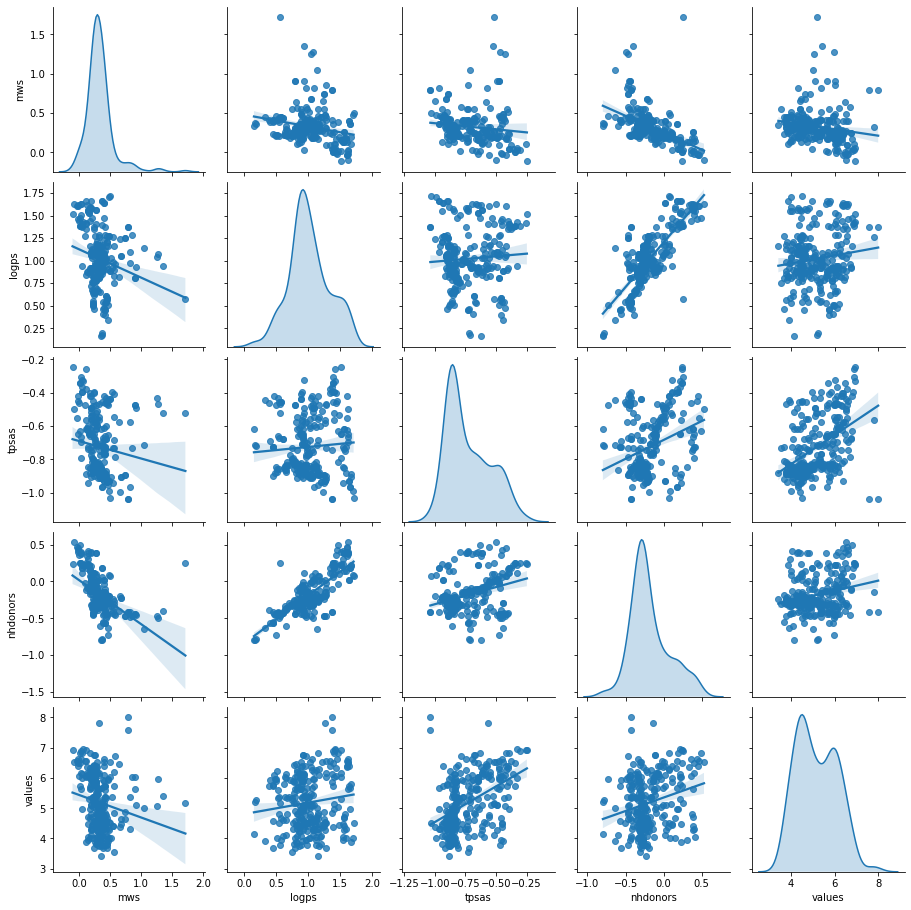

In [88]:
sns.pairplot(global_importances, diag_kind="kde", kind="reg")

In [89]:
np.corrcoef(global_importances.values.T)

array([[ 1.        , -0.21540456, -0.12732387, -0.50530763, -0.17418433],
       [-0.21540456,  1.        ,  0.0668752 ,  0.80324036,  0.1289914 ],
       [-0.12732387,  0.0668752 ,  1.        ,  0.32445848,  0.45504597],
       [-0.50530763,  0.80324036,  0.32445848,  1.        ,  0.24635779],
       [-0.17418433,  0.1289914 ,  0.45504597,  0.24635779,  1.        ]])